# Amazon Fine Food Reviews - Sentiment Analysis using RNN

This notebook implements sentiment analysis on Amazon Fine Food Reviews using RNN models (LSTM and GRU) with GloVe embeddings.

## Assignment Tasks:
1. Download and preprocess the dataset
2. Prepare training, validation, and test sets (5000 positive + 5000 negative for training)
3. Train LSTM and GRU models with GloVe embeddings
4. Vary RNN size [32, 64, 128]
5. Vary number of stacked layers [1, 2, 3, 4]
6. Apply dropout and regularization

## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, LSTM, GRU, Embedding, Dropout, 
                                      Bidirectional, Input, GlobalMaxPooling1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import re
import string
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.7.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Download Dataset

**Note:** Before running this notebook, please:
1. Download the Amazon Fine Food Reviews dataset from: https://www.kaggle.com/snap/amazon-fine-food-reviews
2. Download GloVe vectors from: https://nlp.stanford.edu/data/glove.6B.zip
3. Extract `glove.6B.100d.txt` from the zip file
4. Place both files in the `Assignment-6` directory

For Kaggle dataset, you can use Kaggle API:
```bash
kaggle datasets download -d snap/amazon-fine-food-reviews
unzip amazon-fine-food-reviews.zip
```

In [3]:
!pip install kagglehub

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

100%|██████████| 242M/242M [00:16<00:00, 15.5MB/s] 

Extracting model files...


Path to dataset files: /home/.cache/kagglehub/datasets/snap/amazon-fine-food-reviews/versions/2


In [5]:
# Load the dataset
df = pd.read_csv('Reviews.csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())
print("\nDataset info:")
print(df.info())

Dataset shape: (568454, 10)

First few rows:
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bo

## 3. Data Exploration and Preprocessing

Score distribution:
1     52268
2     29769
3     42640
4     80655
5    363122
Name: Score, dtype: int64


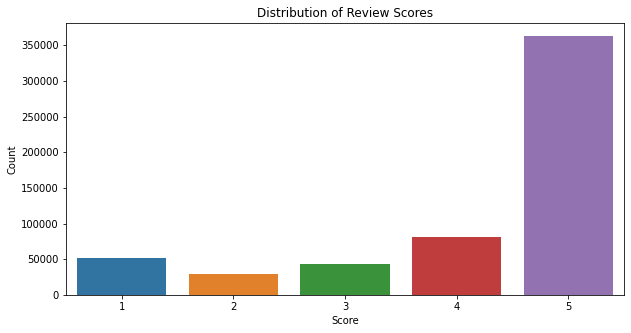


Missing values:
Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


In [6]:
# Check Score distribution
print("Score distribution:")
print(df['Score'].value_counts().sort_index())

# Visualize score distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Score')
plt.title('Distribution of Review Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

## Handle Missing Values

We found missing values in:
- ProfileName: 16 missing values
- Summary: 27 missing values

Since these columns are not used in our sentiment analysis (we only use Text and Score), 
we have several options:

1. **Drop rows with missing values**: Removes 43 rows out of 568,454 (~0.0076%)
2. **Fill missing values**: Replace with placeholder like "Unknown" or empty string
3. **Leave as is**: Since we don't use these columns in the analysis

We'll choose option 1 (drop rows) to maintain data quality and consistency, 
as the number of affected rows is negligible.

In [ ]:
# Handle missing values
print("Dataset shape before handling missing values:", df.shape)
rows_before = len(df)

# Drop rows with missing ProfileName or Summary
df = df.dropna(subset=["ProfileName", "Summary"])

rows_after = len(df)
print("Dataset shape after dropping missing values:", df.shape)
print(f"Rows removed: {rows_before - rows_after}")

# Verify no missing values in these columns
print("
Missing values after cleaning:")
print(df.isnull().sum())

In [7]:
# Create binary sentiment labels
# Score > 3 -> Positive (1), Score <= 3 -> Negative (0)
df['Sentiment'] = (df['Score'] > 3).astype(int)

print("Sentiment distribution:")
print(df['Sentiment'].value_counts())

# Remove any rows with missing text
df = df.dropna(subset=['Text'])

print("\nDataset shape after removing missing text:", df.shape)

Sentiment distribution:
1    443777
0    124677
Name: Sentiment, dtype: int64

Dataset shape after removing missing text: (568454, 11)


In [8]:
# Sample balanced dataset
# 5000 positive and 5000 negative for training
# 2000 each for test and validation

positive_reviews = df[df['Sentiment'] == 1].sample(n=9000, random_state=42)
negative_reviews = df[df['Sentiment'] == 0].sample(n=9000, random_state=42)

# Combine
balanced_df = pd.concat([positive_reviews, negative_reviews]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced dataset shape:", balanced_df.shape)
print("\nSentiment distribution in balanced dataset:")
print(balanced_df['Sentiment'].value_counts())

Balanced dataset shape: (18000, 11)

Sentiment distribution in balanced dataset:
1    9000
0    9000
Name: Sentiment, dtype: int64


In [9]:
# Text preprocessing function
def preprocess_text(text):
    """Clean and preprocess text data"""
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply preprocessing
balanced_df['Cleaned_Text'] = balanced_df['Text'].apply(preprocess_text)

# Show examples
print("Original text:")
print(balanced_df['Text'].iloc[0][:200])
print("\nCleaned text:")
print(balanced_df['Cleaned_Text'].iloc[0][:200])

Original text:
I haven't decorated cakes in years, but I had to make a cake for my grandmother's 100th birthday and wanted only THIS cake mix to use.  It was just as I remembered and was absolutely delicious!  The p

Cleaned text:
i havent decorated cakes in years but i had to make a cake for my grandmothers 100th birthday and wanted only this cake mix to use it was just as i remembered and was absolutely delicious the package 


## 4. Train-Test-Validation Split

In [10]:
# Split data: 10000 train (5000 each), 4000 test (2000 each), 4000 val (2000 each)
# First split: 10000 train, 8000 temp
X = balanced_df['Cleaned_Text'].values
y = balanced_df['Sentiment'].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=8000, random_state=42, stratify=y
)

# Second split: 4000 test, 4000 val
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))
print("Validation set size:", len(X_val))
print("\nTraining set sentiment distribution:")
print("Positive:", np.sum(y_train == 1), "Negative:", np.sum(y_train == 0))
print("Test set sentiment distribution:")
print("Positive:", np.sum(y_test == 1), "Negative:", np.sum(y_test == 0))
print("Validation set sentiment distribution:")
print("Positive:", np.sum(y_val == 1), "Negative:", np.sum(y_val == 0))

Training set size: 10000
Test set size: 4000
Validation set size: 4000

Training set sentiment distribution:
Positive: 5000 Negative: 5000
Test set sentiment distribution:
Positive: 2000 Negative: 2000
Validation set sentiment distribution:
Positive: 2000 Negative: 2000


## 5. Tokenization and Sequence Padding

In [11]:
# Tokenization parameters
MAX_WORDS = 10000  # Vocabulary size
MAX_LEN = 100  # Maximum sequence length (adjust based on computation availability)

# Create and fit tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print("Vocabulary size:", len(tokenizer.word_index))
print("Training sequences shape:", X_train_pad.shape)
print("Test sequences shape:", X_test_pad.shape)
print("Validation sequences shape:", X_val_pad.shape)

Vocabulary size: 30132
Training sequences shape: (10000, 100)
Test sequences shape: (4000, 100)
Validation sequences shape: (4000, 100)


## 6. Load GloVe Embeddings

In [12]:
# Load GloVe embeddings
EMBEDDING_DIM = 100
GLOVE_FILE = 'glove.6B.100d.txt'

print("Loading GloVe embeddings...")
embeddings_index = {}

with open(GLOVE_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} word vectors.")

# Create embedding matrix
word_index = tokenizer.word_index
num_words = min(MAX_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(f"Embedding matrix shape: {embedding_matrix.shape}")

# Calculate coverage
found_words = 0
for word, i in word_index.items():
    if i >= MAX_WORDS:
        continue
    if word in embeddings_index:
        found_words += 1

print(f"Coverage: {found_words}/{min(MAX_WORDS, len(word_index))} words found in GloVe")

Loading GloVe embeddings...
Loaded 400000 word vectors.
Embedding matrix shape: (10000, 100)
Coverage: 9118/10000 words found in GloVe


## 7. Model Building Functions

In [13]:
def build_rnn_model(rnn_type='LSTM', rnn_units=64, num_layers=1, dropout_rate=0.0, 
                     embedding_matrix=None, max_words=MAX_WORDS, max_len=MAX_LEN, 
                     embedding_dim=EMBEDDING_DIM):
    """
    Build RNN model with GloVe embeddings
    
    Parameters:
    - rnn_type: 'LSTM' or 'GRU'
    - rnn_units: Number of units in RNN layer
    - num_layers: Number of stacked RNN layers
    - dropout_rate: Dropout rate for regularization
    - embedding_matrix: Pre-trained GloVe embeddings
    - max_words: Vocabulary size
    - max_len: Maximum sequence length
    - embedding_dim: Embedding dimension
    """
    
    model = Sequential()
    
    # Embedding layer with GloVe weights
    if embedding_matrix is not None:
        model.add(Embedding(
            input_dim=max_words,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=False  # Freeze GloVe embeddings
        ))
    else:
        model.add(Embedding(
            input_dim=max_words,
            output_dim=embedding_dim,
            input_length=max_len
        ))
    
    # Stack RNN layers
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Return sequences for all but last layer
        
        if rnn_type == 'LSTM':
            model.add(LSTM(rnn_units, return_sequences=return_sequences))
        elif rnn_type == 'GRU':
            model.add(GRU(rnn_units, return_sequences=return_sequences))
        
        # Add dropout after each RNN layer
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    
    # Fully connected layer with ReLU activation
    model.add(Dense(64, activation='relu'))
    
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("Model building function created successfully!")

Model building function created successfully!


In [14]:
def train_and_evaluate(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=20):
    """
    Train and evaluate model
    """
    print(f"\n{'='*80}")
    print(f"Training {model_name}")
    print(f"{'='*80}\n")
    
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=64,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    # Predictions
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    # Metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\n{model_name} Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_title(f'{model_name} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_title(f'{model_name} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return history, test_accuracy, auc_score

print("Training function created successfully!")

Training function created successfully!


## 8. Task (iii): Train Base Models - LSTM and GRU with 1 Layer, 64 Units

Building LSTM model...


2025-11-12 10:40:03.838299: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-11-12 10:40:03.838705: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22666 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:41:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,046,465
Trainable params: 46,465
Non-trainable params: 1,000,000
_________________________________________________________________

Training LSTM (1 Layer, 64 Units)

Epoch 1/20


2025-11-12 10:40:06.694008: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


157/157 [==============================] - 7s 25ms/step - loss: 0.6888 - accuracy: 0.5390 - val_loss: 0.6811 - val_accuracy: 0.5677 - lr: 0.0010
Epoch 2/20
157/157 [==============================] - 3s 16ms/step - loss: 0.6822 - accuracy: 0.5602 - val_loss: 0.6888 - val_accuracy: 0.5435 - lr: 0.0010
Epoch 3/20
157/157 [==============================] - 3s 16ms/step - loss: 0.6836 - accuracy: 0.5479 - val_loss: 0.6859 - val_accuracy: 0.5525 - lr: 0.0010
Epoch 4/20
157/157 [==============================] - 3s 16ms/step - loss: 0.6730 - accuracy: 0.5835 - val_loss: 0.6584 - val_accuracy: 0.6423 - lr: 0.0010
Epoch 5/20
157/157 [==============================] - 3s 16ms/step - loss: 0.6448 - accuracy: 0.6455 - val_loss: 0.6056 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 6/20
157/157 [==============================] - 3s 16ms/step - loss: 0.6365 - accuracy: 0.6482 - val_loss: 0.6861 - val_accuracy: 0.5425 - lr: 0.0010
Epoch 7/20
157/157 [==============================] - 3s 16ms/step - loss: 

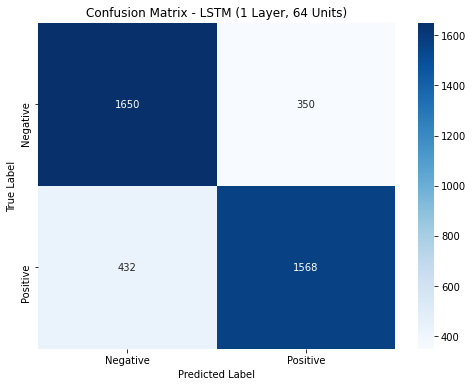

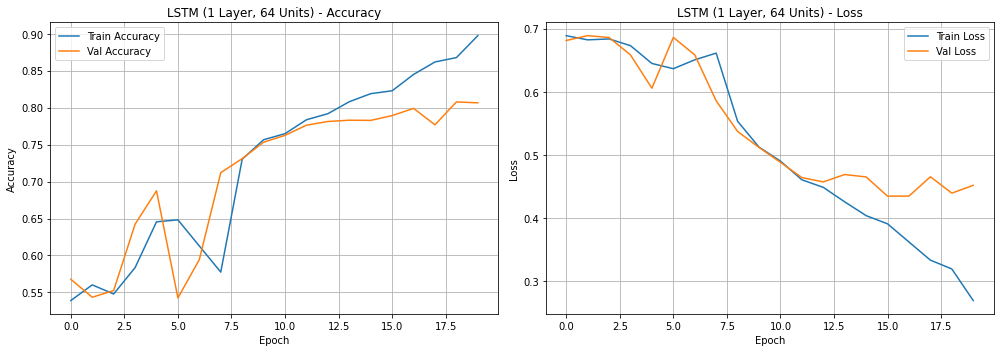

In [15]:
# Dictionary to store results
results = []

# Model 1: LSTM with 1 layer, 64 units
print("Building LSTM model...")
lstm_model = build_rnn_model(
    rnn_type='LSTM',
    rnn_units=64,
    num_layers=1,
    dropout_rate=0.0,
    embedding_matrix=embedding_matrix
)

lstm_model.summary()

history_lstm, acc_lstm, auc_lstm = train_and_evaluate(
    lstm_model, 
    "LSTM (1 Layer, 64 Units)",
    X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test
)

results.append({
    'Model': 'LSTM',
    'Layers': 1,
    'Units': 64,
    'Dropout': 0.0,
    'Accuracy': acc_lstm,
    'AUC': auc_lstm
})

Building GRU model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 gru (GRU)                   (None, 64)                31872     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,036,097
Trainable params: 36,097
Non-trainable params: 1,000,000
_________________________________________________________________

Training GRU (1 Layer, 64 Units)

Epoch 1/20
157/157 [==============================] - 5s 19ms/step - loss: 0.6902 - accuracy: 0.5329 - val_loss: 0

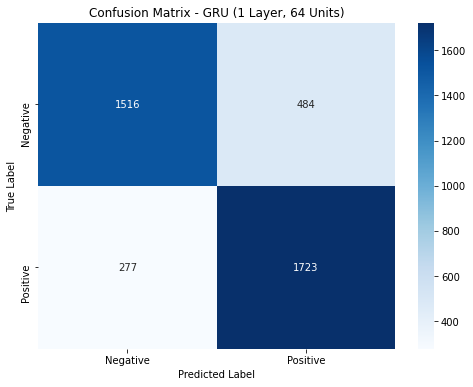

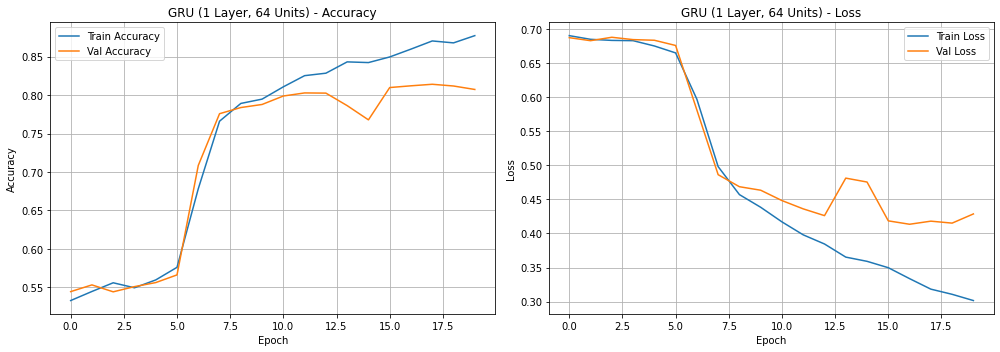

In [16]:
# Model 2: GRU with 1 layer, 64 units
print("Building GRU model...")
gru_model = build_rnn_model(
    rnn_type='GRU',
    rnn_units=64,
    num_layers=1,
    dropout_rate=0.0,
    embedding_matrix=embedding_matrix
)

gru_model.summary()

history_gru, acc_gru, auc_gru = train_and_evaluate(
    gru_model, 
    "GRU (1 Layer, 64 Units)",
    X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test
)

results.append({
    'Model': 'GRU',
    'Layers': 1,
    'Units': 64,
    'Dropout': 0.0,
    'Accuracy': acc_gru,
    'AUC': auc_gru
})

In [17]:
# Compare base models
print("\n" + "="*80)
print("COMPARISON: LSTM vs GRU (Base Models)")
print("="*80)
print(f"LSTM - Accuracy: {acc_lstm:.4f}, AUC: {auc_lstm:.4f}")
print(f"GRU  - Accuracy: {acc_gru:.4f}, AUC: {auc_gru:.4f}")

# Determine best model
if acc_lstm > acc_gru:
    best_base_model = 'LSTM'
    best_base_acc = acc_lstm
else:
    best_base_model = 'GRU'
    best_base_acc = acc_gru

print(f"\nBest Base Model: {best_base_model} with Accuracy: {best_base_acc:.4f}")


COMPARISON: LSTM vs GRU (Base Models)
LSTM - Accuracy: 0.8045, AUC: 0.8915
GRU  - Accuracy: 0.8098, AUC: 0.8990

Best Base Model: GRU with Accuracy: 0.8098


## 9. Task (iv): Vary RNN Size [32, 128] for Best Model


Training GRU with 32 units

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 gru_1 (GRU)                 (None, 32)                12864     
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,015,041
Trainable params: 15,041
Non-trainable params: 1,000,000
_________________________________________________________________

Training GRU (1 Layer, 32 Units)

Epoch 1/20
157/157 [==============================] - 5s 20ms/step - loss: 0.6897 - accuracy: 0.5358 - val_

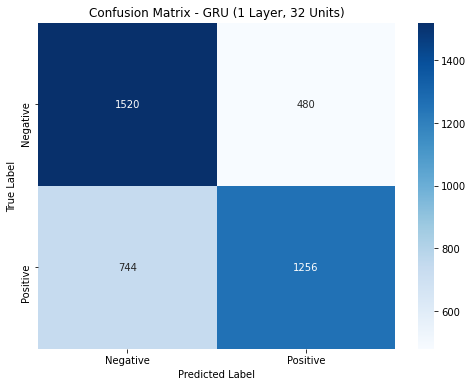

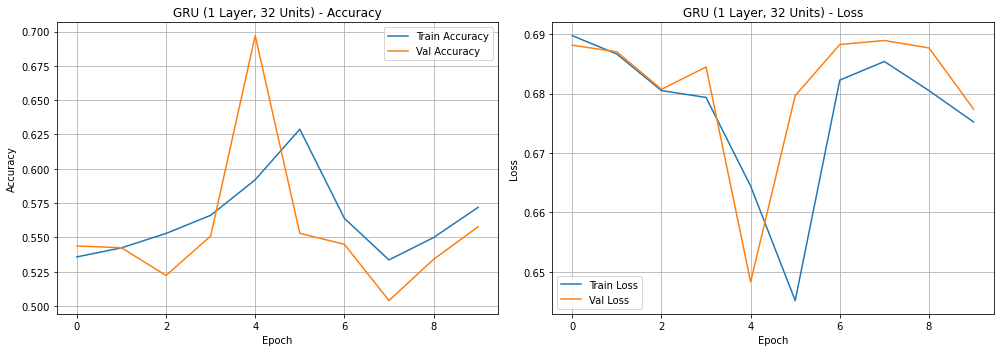


Training GRU with 128 units

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 gru_2 (GRU)                 (None, 128)               88320     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,096,641
Trainable params: 96,641
Non-trainable params: 1,000,000
_________________________________________________________________

Training GRU (1 Layer, 128 Units)

Epoch 1/20
157/157 [==============================] - 5s 23ms/step - loss: 0.6904 - accuracy: 0.5321 - va

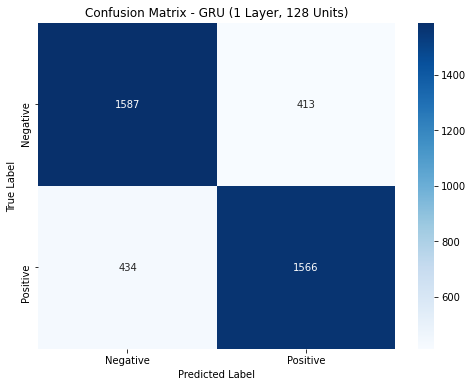

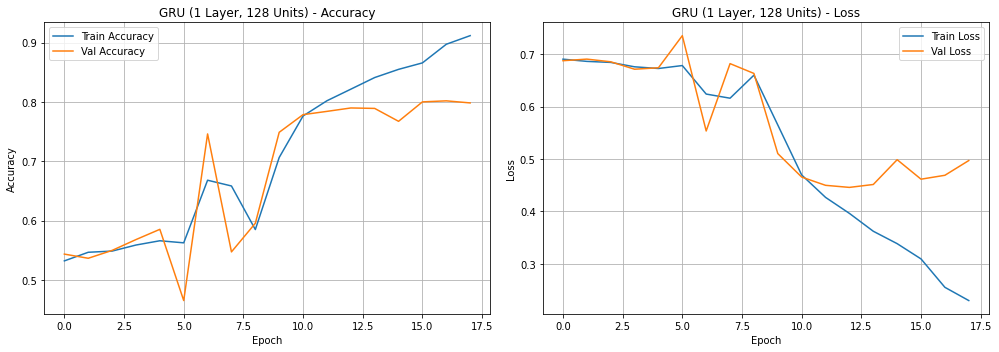

In [18]:
# Experiment with different RNN sizes
rnn_sizes = [32, 128]

for units in rnn_sizes:
    print(f"\n{'='*80}")
    print(f"Training {best_base_model} with {units} units")
    print(f"{'='*80}\n")
    
    model = build_rnn_model(
        rnn_type=best_base_model,
        rnn_units=units,
        num_layers=1,
        dropout_rate=0.0,
        embedding_matrix=embedding_matrix
    )
    
    model.summary()
    
    history, acc, auc = train_and_evaluate(
        model, 
        f"{best_base_model} (1 Layer, {units} Units)",
        X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test
    )
    
    results.append({
        'Model': best_base_model,
        'Layers': 1,
        'Units': units,
        'Dropout': 0.0,
        'Accuracy': acc,
        'AUC': auc
    })

In [19]:
# Find best RNN size
results_df = pd.DataFrame(results)
best_size_idx = results_df['Accuracy'].idxmax()
best_size_row = results_df.iloc[best_size_idx]
best_rnn_size = int(best_size_row['Units'])

print("\n" + "="*80)
print("RESULTS: Varying RNN Size")
print("="*80)
print(results_df[results_df['Layers'] == 1].to_string(index=False))
print(f"\nBest RNN Size: {best_rnn_size} units with Accuracy: {best_size_row['Accuracy']:.4f}")


RESULTS: Varying RNN Size
Model  Layers  Units  Dropout  Accuracy       AUC
 LSTM       1     64      0.0   0.80450  0.891454
  GRU       1     64      0.0   0.80975  0.898979
  GRU       1     32      0.0   0.69400  0.750221
  GRU       1    128      0.0   0.78825  0.872172

Best RNN Size: 64 units with Accuracy: 0.8098


## 10. Task (v): Vary Number of Stacked Layers [2, 3, 4]


Training GRU with 2 layers, 64 units each

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 gru_3 (GRU)                 (None, 100, 64)           31872     
                                                                 
 gru_4 (GRU)                 (None, 64)                24960     
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,061,057
Trainable params: 61,057
Non-trainable params: 1,000,000
_____________________________________________________________

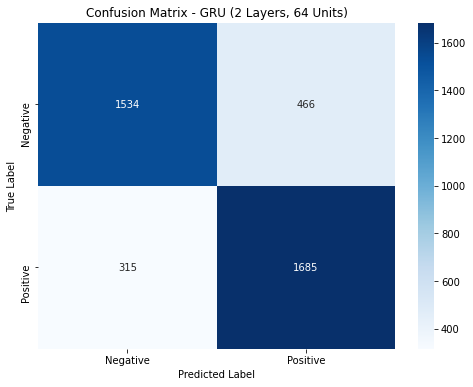

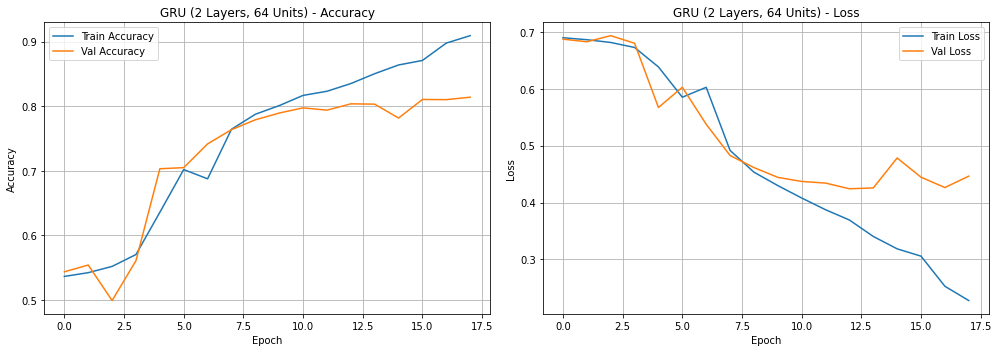


Training GRU with 3 layers, 64 units each

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 gru_5 (GRU)                 (None, 100, 64)           31872     
                                                                 
 gru_6 (GRU)                 (None, 100, 64)           24960     
                                                                 
 gru_7 (GRU)                 (None, 64)                24960     
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total para

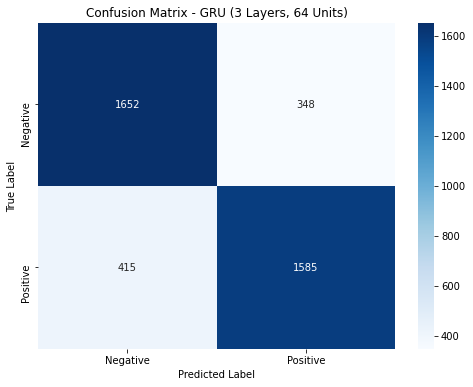

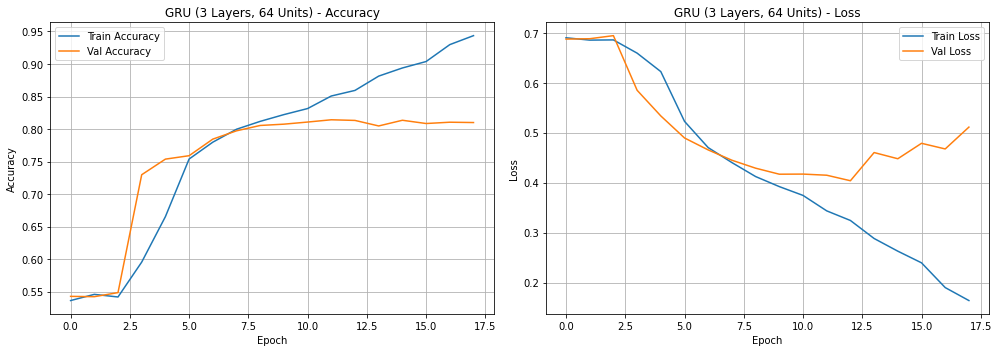


Training GRU with 4 layers, 64 units each

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 gru_8 (GRU)                 (None, 100, 64)           31872     
                                                                 
 gru_9 (GRU)                 (None, 100, 64)           24960     
                                                                 
 gru_10 (GRU)                (None, 100, 64)           24960     
                                                                 
 gru_11 (GRU)                (None, 64)                24960     
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 

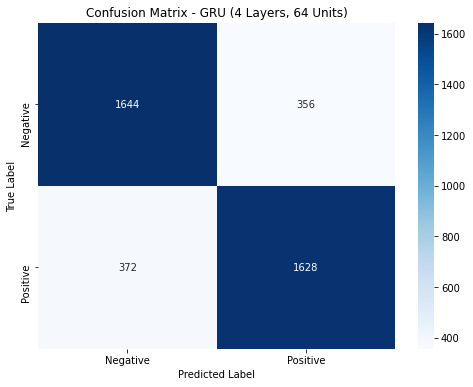

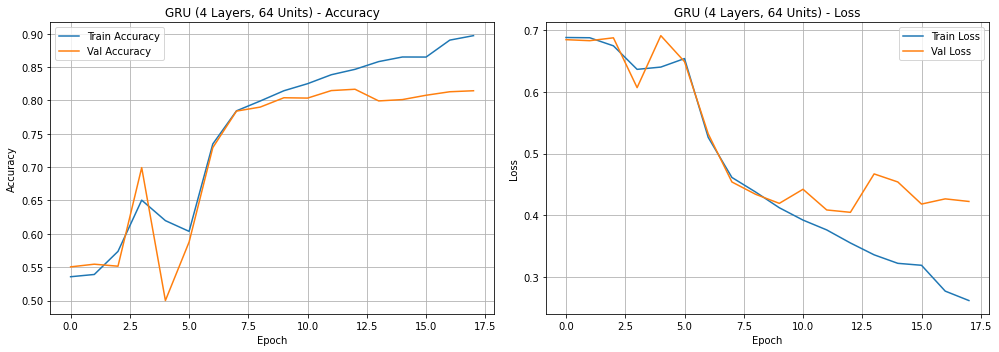

In [20]:
# Experiment with different number of layers
num_layers_list = [2, 3, 4]

for num_layers in num_layers_list:
    print(f"\n{'='*80}")
    print(f"Training {best_base_model} with {num_layers} layers, {best_rnn_size} units each")
    print(f"{'='*80}\n")
    
    model = build_rnn_model(
        rnn_type=best_base_model,
        rnn_units=best_rnn_size,
        num_layers=num_layers,
        dropout_rate=0.0,
        embedding_matrix=embedding_matrix
    )
    
    model.summary()
    
    history, acc, auc = train_and_evaluate(
        model, 
        f"{best_base_model} ({num_layers} Layers, {best_rnn_size} Units)",
        X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test
    )
    
    results.append({
        'Model': best_base_model,
        'Layers': num_layers,
        'Units': best_rnn_size,
        'Dropout': 0.0,
        'Accuracy': acc,
        'AUC': auc
    })

In [21]:
# Find best number of layers
results_df = pd.DataFrame(results)
best_layers_idx = results_df['Accuracy'].idxmax()
best_layers_row = results_df.iloc[best_layers_idx]
best_num_layers = int(best_layers_row['Layers'])

print("\n" + "="*80)
print("RESULTS: Varying Number of Layers")
print("="*80)
print(results_df[results_df['Units'] == best_rnn_size].to_string(index=False))
print(f"\nBest Configuration: {best_num_layers} layers with Accuracy: {best_layers_row['Accuracy']:.4f}")


RESULTS: Varying Number of Layers
Model  Layers  Units  Dropout  Accuracy       AUC
 LSTM       1     64      0.0   0.80450  0.891454
  GRU       1     64      0.0   0.80975  0.898979
  GRU       2     64      0.0   0.80475  0.893315
  GRU       3     64      0.0   0.80925  0.900627
  GRU       4     64      0.0   0.81800  0.900654

Best Configuration: 4 layers with Accuracy: 0.8180


## 11. Task (vi): Apply Dropout and Regularization


Training GRU with 4 layers, 64 units, Dropout=0.1

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 gru_12 (GRU)                (None, 100, 64)           31872     
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 gru_13 (GRU)                (None, 100, 64)           24960     
                                                                 
 dropout_1 (Dropout)         (None, 100, 64)           0         
                                                                 
 gru_14 (GRU)                (None, 100, 64)           24960     
                                                                 
 d

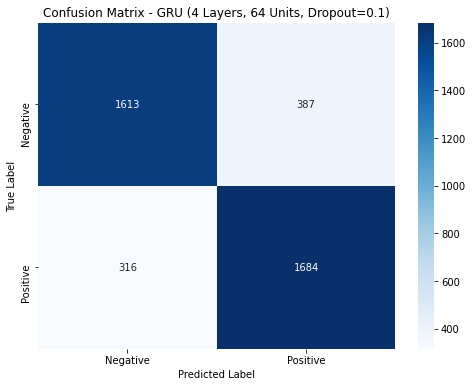

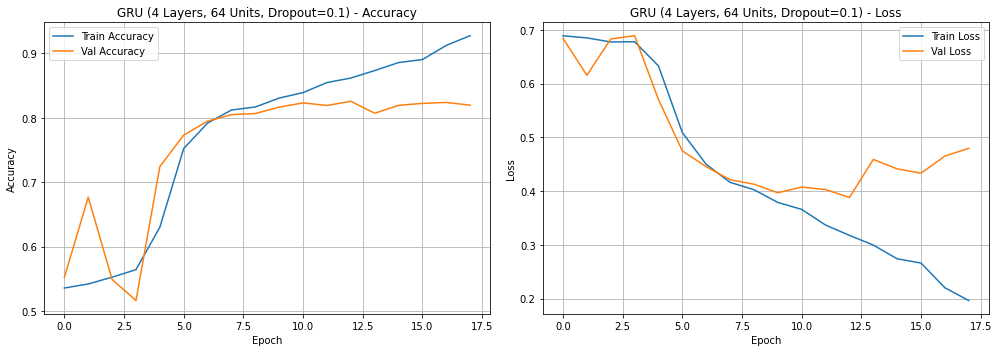

In [22]:
# Try dropout rate of 0.1
dropout_rate = 0.1

print(f"\n{'='*80}")
print(f"Training {best_base_model} with {best_num_layers} layers, {best_rnn_size} units, Dropout={dropout_rate}")
print(f"{'='*80}\n")

model_dropout = build_rnn_model(
    rnn_type=best_base_model,
    rnn_units=best_rnn_size,
    num_layers=best_num_layers,
    dropout_rate=dropout_rate,
    embedding_matrix=embedding_matrix
)

model_dropout.summary()

history_dropout, acc_dropout, auc_dropout = train_and_evaluate(
    model_dropout, 
    f"{best_base_model} ({best_num_layers} Layers, {best_rnn_size} Units, Dropout={dropout_rate})",
    X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test
)

results.append({
    'Model': best_base_model,
    'Layers': best_num_layers,
    'Units': best_rnn_size,
    'Dropout': dropout_rate,
    'Accuracy': acc_dropout,
    'AUC': auc_dropout
})


Training GRU with 4 layers, 64 units, Dropout=0.2

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 gru_16 (GRU)                (None, 100, 64)           31872     
                                                                 
 dropout_5 (Dropout)         (None, 100, 64)           0         
                                                                 
 gru_17 (GRU)                (None, 100, 64)           24960     
                                                                 
 dropout_6 (Dropout)         (None, 100, 64)           0         
                                                                 
 gru_18 (GRU)                (None, 100, 64)           24960     
                                                                 
 d

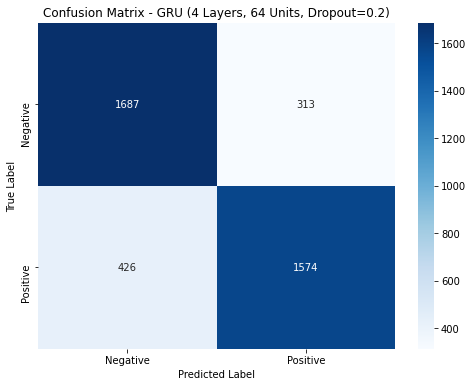

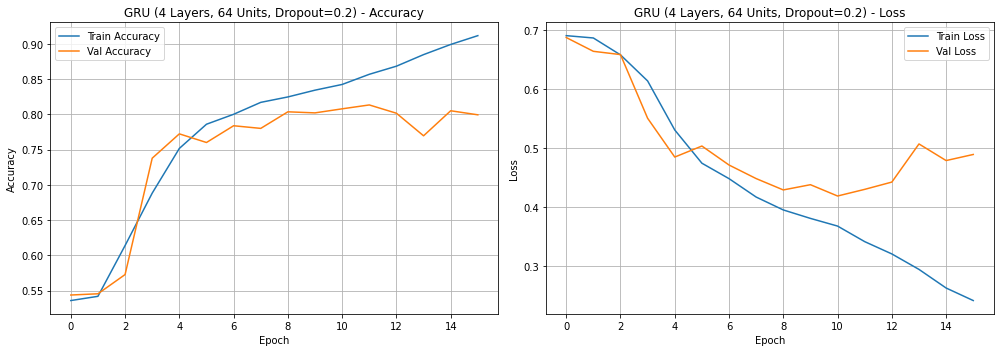


Training GRU with 4 layers, 64 units, Dropout=0.3

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 gru_20 (GRU)                (None, 100, 64)           31872     
                                                                 
 dropout_10 (Dropout)        (None, 100, 64)           0         
                                                                 
 gru_21 (GRU)                (None, 100, 64)           24960     
                                                                 
 dropout_11 (Dropout)        (None, 100, 64)           0         
                                                                 
 gru_22 (GRU)                (None, 100, 64)           24960     
                                                                 
 d

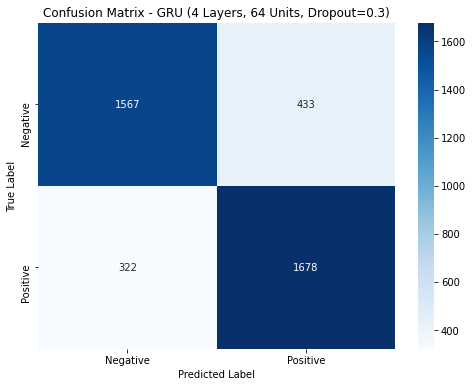

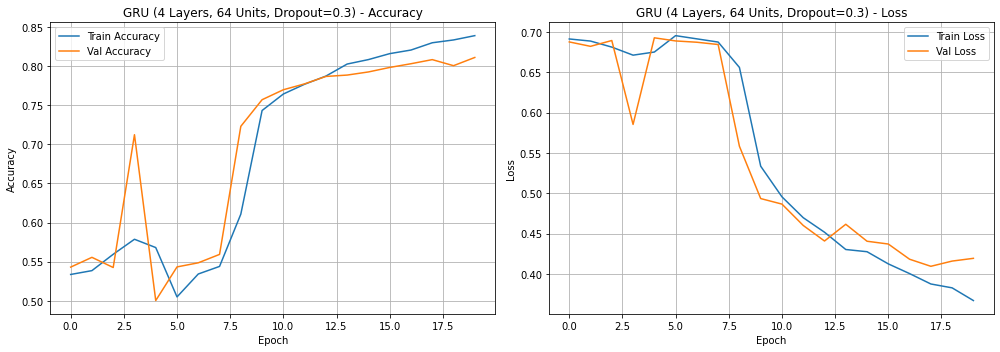

In [23]:
# Try additional dropout rates
additional_dropout_rates = [0.2, 0.3]

for dropout_rate in additional_dropout_rates:
    print(f"\n{'='*80}")
    print(f"Training {best_base_model} with {best_num_layers} layers, {best_rnn_size} units, Dropout={dropout_rate}")
    print(f"{'='*80}\n")
    
    model = build_rnn_model(
        rnn_type=best_base_model,
        rnn_units=best_rnn_size,
        num_layers=best_num_layers,
        dropout_rate=dropout_rate,
        embedding_matrix=embedding_matrix
    )
    
    model.summary()
    
    history, acc, auc = train_and_evaluate(
        model, 
        f"{best_base_model} ({best_num_layers} Layers, {best_rnn_size} Units, Dropout={dropout_rate})",
        X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test
    )
    
    results.append({
        'Model': best_base_model,
        'Layers': best_num_layers,
        'Units': best_rnn_size,
        'Dropout': dropout_rate,
        'Accuracy': acc,
        'AUC': auc
    })

## 12. Final Results and Comparison

In [24]:
# Display all results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("ALL EXPERIMENT RESULTS (Sorted by Accuracy)")
print("="*80)
print(results_df.to_string(index=False))

# Find best overall model
best_idx = results_df['Accuracy'].idxmax()
best_model = results_df.iloc[best_idx]

print("\n" + "="*80)
print("BEST MODEL CONFIGURATION")
print("="*80)
print(f"Model Type: {best_model['Model']}")
print(f"Number of Layers: {int(best_model['Layers'])}")
print(f"Units per Layer: {int(best_model['Units'])}")
print(f"Dropout Rate: {best_model['Dropout']}")
print(f"Test Accuracy: {best_model['Accuracy']:.4f}")
print(f"AUC-ROC Score: {best_model['AUC']:.4f}")
print("="*80)


ALL EXPERIMENT RESULTS (Sorted by Accuracy)
Model  Layers  Units  Dropout  Accuracy       AUC
  GRU       4     64      0.1   0.82425  0.907465
  GRU       4     64      0.0   0.81800  0.900654
  GRU       4     64      0.2   0.81525  0.898391
  GRU       4     64      0.3   0.81125  0.896941
  GRU       1     64      0.0   0.80975  0.898979
  GRU       3     64      0.0   0.80925  0.900627
  GRU       2     64      0.0   0.80475  0.893315
 LSTM       1     64      0.0   0.80450  0.891454
  GRU       1    128      0.0   0.78825  0.872172
  GRU       1     32      0.0   0.69400  0.750221

BEST MODEL CONFIGURATION
Model Type: GRU
Number of Layers: 4
Units per Layer: 64
Dropout Rate: 0.1
Test Accuracy: 0.8242
AUC-ROC Score: 0.9075


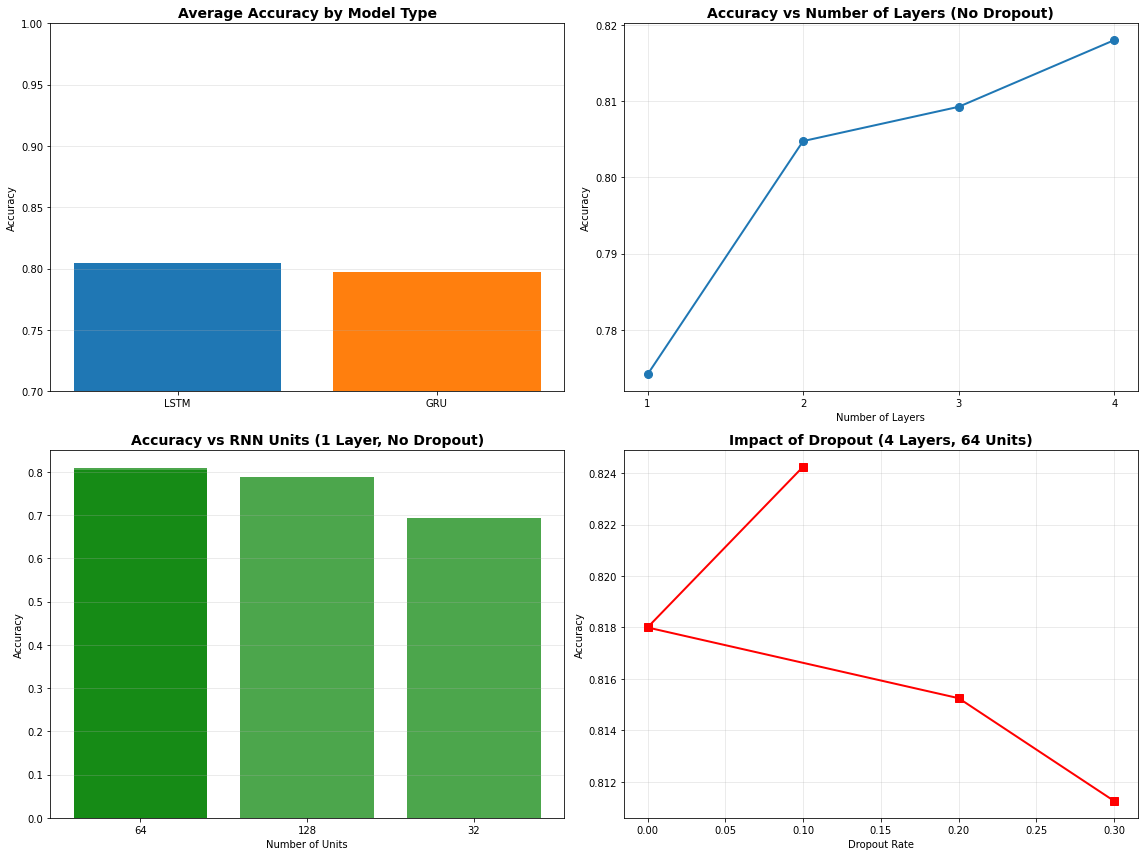

In [25]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy by Model Type
model_comparison = results_df.groupby('Model')['Accuracy'].mean().sort_values(ascending=False)
axes[0, 0].bar(model_comparison.index, model_comparison.values, color=['#1f77b4', '#ff7f0e'])
axes[0, 0].set_title('Average Accuracy by Model Type', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([0.7, 1.0])
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Accuracy by Number of Layers
layer_comparison = results_df[results_df['Dropout'] == 0.0].groupby('Layers')['Accuracy'].mean()
axes[0, 1].plot(layer_comparison.index, layer_comparison.values, marker='o', linewidth=2, markersize=8)
axes[0, 1].set_title('Accuracy vs Number of Layers (No Dropout)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Layers')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks([1, 2, 3, 4])

# 3. Accuracy by RNN Units (1 layer, no dropout)
units_comparison = results_df[(results_df['Layers'] == 1) & (results_df['Dropout'] == 0.0)]
axes[1, 0].bar(units_comparison['Units'].astype(str), units_comparison['Accuracy'], color='green', alpha=0.7)
axes[1, 0].set_title('Accuracy vs RNN Units (1 Layer, No Dropout)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Units')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Impact of Dropout
dropout_comparison = results_df[(results_df['Layers'] == best_num_layers) & 
                                 (results_df['Units'] == best_rnn_size)]
axes[1, 1].plot(dropout_comparison['Dropout'], dropout_comparison['Accuracy'], 
                marker='s', linewidth=2, markersize=8, color='red')
axes[1, 1].set_title(f'Impact of Dropout ({best_num_layers} Layers, {best_rnn_size} Units)', 
                     fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Dropout Rate')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Train and Save Final Best Model

In [26]:
# Build and train final best model
print(f"\n{'='*80}")
print(f"Training FINAL BEST MODEL")
print(f"{'='*80}\n")

final_model = build_rnn_model(
    rnn_type=best_model['Model'],
    rnn_units=int(best_model['Units']),
    num_layers=int(best_model['Layers']),
    dropout_rate=best_model['Dropout'],
    embedding_matrix=embedding_matrix
)

final_model.summary()

# Callbacks for final model
checkpoint = ModelCheckpoint(
    'best_sentiment_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train final model
final_history = final_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

print("\nFinal model saved as 'best_sentiment_model.h5'")


Training FINAL BEST MODEL

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 100)          1000000   
                                                                 
 gru_24 (GRU)                (None, 100, 64)           31872     
                                                                 
 dropout_15 (Dropout)        (None, 100, 64)           0         
                                                                 
 gru_25 (GRU)                (None, 100, 64)           24960     
                                                                 
 dropout_16 (Dropout)        (None, 100, 64)           0         
                                                                 
 gru_26 (GRU)                (None, 100, 64)           24960     
                                                                 
 dropout_17 (Dropout)    


FINAL MODEL PERFORMANCE ON TEST SET
Test Loss: 0.4109
Test Accuracy: 0.8133
AUC-ROC Score: 0.8956

Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.83      0.82      2000
    Positive       0.83      0.79      0.81      2000

    accuracy                           0.81      4000
   macro avg       0.81      0.81      0.81      4000
weighted avg       0.81      0.81      0.81      4000



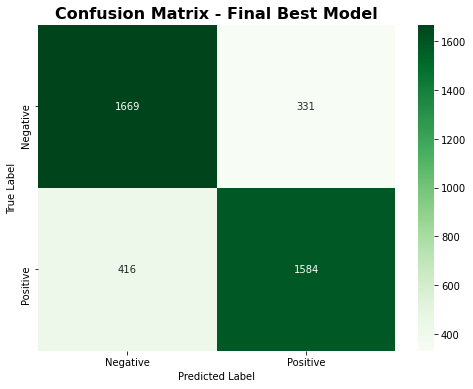

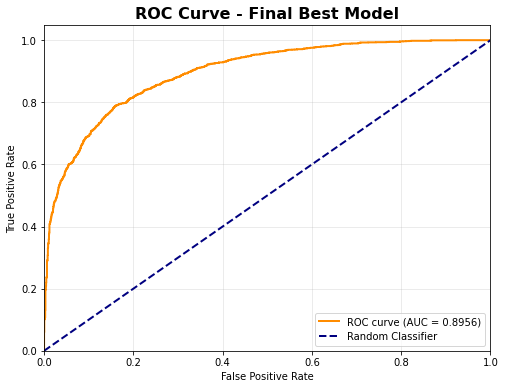

In [27]:
# Final evaluation on test set
test_loss, test_accuracy = final_model.evaluate(X_test_pad, y_test, verbose=0)
y_pred_proba = final_model.predict(X_test_pad, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()
auc_score = roc_auc_score(y_test, y_pred_proba)

print("\n" + "="*80)
print("FINAL MODEL PERFORMANCE ON TEST SET")
print("="*80)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"AUC-ROC Score: {auc_score:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Final Best Model', fontsize=16, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Final Best Model', fontsize=16, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()